Features: 42, Mean PPV (1%): 0.5465217391304349
Features: 41, Mean PPV (1%): 0.537391304347826
Features: 40, Mean PPV (1%): 0.551304347826087
Features: 39, Mean PPV (1%): 0.545217391304348
Features: 38, Mean PPV (1%): 0.5643478260869563
Features: 37, Mean PPV (1%): 0.5743478260869566
Features: 36, Mean PPV (1%): 0.5791304347826087
Features: 35, Mean PPV (1%): 0.5926086956521739
Features: 34, Mean PPV (1%): 0.6065217391304347
Features: 33, Mean PPV (1%): 0.5978260869565217
Features: 32, Mean PPV (1%): 0.6243478260869566
Features: 31, Mean PPV (1%): 0.6304347826086956
Features: 30, Mean PPV (1%): 0.6513043478260869
Features: 29, Mean PPV (1%): 0.6413043478260869
Features: 28, Mean PPV (1%): 0.668695652173913
Features: 27, Mean PPV (1%): 0.6630434782608694
Features: 26, Mean PPV (1%): 0.6665217391304347
Features: 25, Mean PPV (1%): 0.6547826086956522
Features: 24, Mean PPV (1%): 0.6834782608695652
Features: 23, Mean PPV (1%): 0.6813043478260871
Features: 22, Mean PPV (1%): 0.6730434782608

/var/folders/j2/g16nd4ld17z43clcp8bbjqv80000gn/T/ipykernel_31642/107439498.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


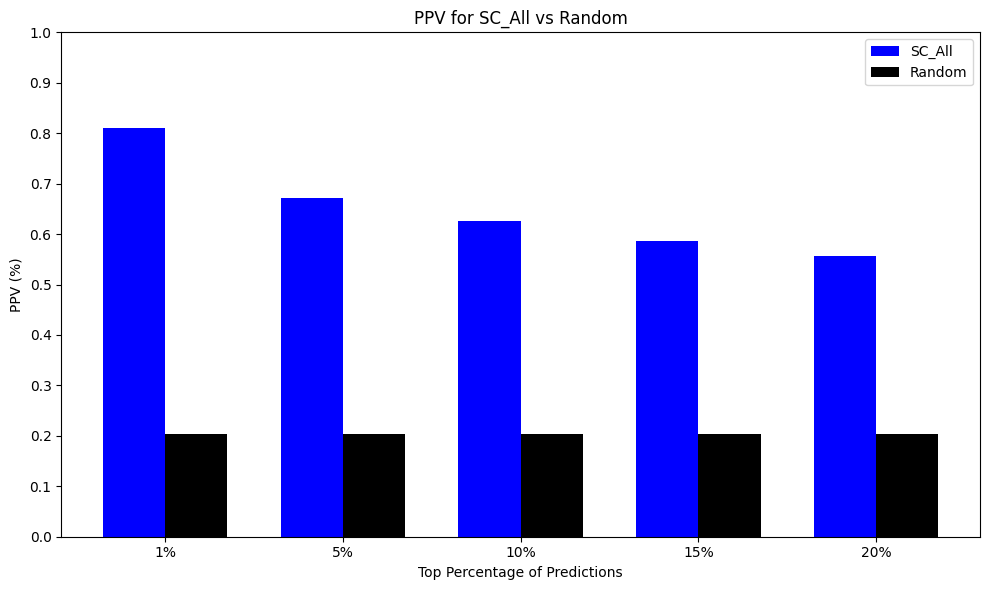

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt




# CMIM ranking of features pre-calculated
CMIM_RANKING = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']

PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20%
ITERATIONS = 100  # Use 100 iterations as per the article




def calculate_top_percentile_ppv(probabilities, true_labels, percentiles):
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = true_labels[sorted_indices]
    ppv_percentiles = []

    for p in percentiles:
        n_top = int(len(sorted_labels) * (p / 100))
        if n_top == 0:
            ppv_percentiles.append(0)
        else:
            top_labels = sorted_labels[:n_top]
            ppv = np.sum(top_labels) / len(top_labels)  # Precision = TP / (TP + FP)
            ppv_percentiles.append(ppv)

    return ppv_percentiles


def load_discretized_data():
    file_path = './cerevisiae_data.xls' 
    discretized_data = pd.read_excel(file_path, sheet_name='entropy discretized')
    columns_with_symbols = discretized_data.columns[2:]  # Skip 'Essential' and 'orf_id'
    label_encoders = {}

    # Transform categorical data to numerical
    for column in columns_with_symbols:
        le = LabelEncoder()
        discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
        label_encoders[column] = le

    return discretized_data.drop(columns=['Essential', 'orf_id']), discretized_data['Essential']


def plot_ppv_results(final_ppv, percentiles):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = [f'{p}%' for p in percentiles]
    random_ppv = [np.mean(y)] * len(percentiles)  # Random baseline
    width = 0.35

    ax.bar(np.arange(len(percentiles)) - width / 2, final_ppv, width, label='SC_All', color='blue')
    ax.bar(np.arange(len(percentiles)) + width / 2, random_ppv, width, label='Random', color='black')
    ax.set_xlabel('Top Percentage of Predictions')
    ax.set_ylabel('PPV (%)')
    ax.set_title('PPV for SC_All vs Random')
    ax.set_xticks(np.arange(len(percentiles)))
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.legend()
    fig.tight_layout()
    fig.show()
    

def calcolate_boostrap_iteration(X):
    for _ in range(ITERATIONS):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.5, stratify=y
        )

        # Oversampling the minority class
        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        X_train_oversampled, y_train_oversampled = resample(
            X_train_minority, y_train_minority,
            replace=True,
            n_samples=np.sum(y_train == 0),  # Balance with the majority class
            random_state=42
        )

        X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        # Calculate PPV for this iteration
        ppv_iteration = calculate_top_percentile_ppv(y_prob, y_test.to_numpy(), PERCENTILES)
        return ppv_iteration


# --- Main script ---

X, y = load_discretized_data()

X_ranked = X[CMIM_RANKING]

optimal_features = None # Optimal number of features that maximizes PPV
highest_ppv_1 = 0 # Highest PPV at 1% found with optimal features
final_ppv_scores = []  # Store PPV scores for each iteration

for i in range(len(CMIM_RANKING), 0, -1):
    X_selected = X_ranked.iloc[:, :i]
    ppv_1_scores = []

    # Bootstrap iterations
    for _ in range(ITERATIONS):
        ppv_iteration = calcolate_boostrap_iteration(X_selected)
        ppv_1_scores.append(ppv_iteration[0])

    mean_ppv_1 = np.mean(ppv_1_scores)
    print(f"Features: {i}, Mean PPV (1%): {mean_ppv_1}")

    if mean_ppv_1 > highest_ppv_1:
        highest_ppv_1 = mean_ppv_1
        optimal_features = i

print("Highest PPV (1%):", highest_ppv_1)
print("Optimal number of features:", optimal_features)

# Final evaluation with optimal features
X_optimal = X_ranked.iloc[:, :optimal_features]

for _ in range(ITERATIONS):
    ppv_iteration = calcolate_boostrap_iteration(X_optimal)
    final_ppv_scores.append(ppv_iteration)

# Calculate mean PPV across iterations
final_ppv = np.mean(final_ppv_scores, axis=0)
print("Final PPV Percentiles:", final_ppv)




plot_ppv_results(final_ppv, PERCENTILES)